<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA 
</center></font>


<center><h2>Proyecto 1</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Esteban Cordova</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>
 

In [1]:
from IPython.display import IFrame, display
filepath = "Proyecto_1_EIE401.pdf"
IFrame(filepath, width=700, height=400)

Debes usar el sitio https://gwosc.org/eventapi/html/GWTC/, donde encuentras todo el catálogo de observaciones con los datos en diferentes formatos. Debes seleccionar una detección para tu estudio y descargar los datos correspondientes (H5 o TXT), lo que posteriormente deberás tratar de manera digital como audio (serie de tiempo).
tip: Te recomiendo tomar la serie de tiempo corta (32 segundos) para facilitar el análisis, y asegurarte de tomar la tasa de muestreo más alta.
tip: Asegúrate de tomar un caso cuyo espectrograma de muestra, indique una señal clara y fuerte para facilitar tu trabajo, de otra forma es posible que no logres aislarla lo suficiente.


## 1. Carga de Datos


C:\Users\esteb\AppData\Local\Temp\ipykernel_5992\2368080536.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('H-H1_GWOSC_16KHZ_R1-1264316101-32.txt') #Leo el archivo descomprimido y lo guardo en un dataframe


[1.04562121e-21 1.71893665e-20 9.49254981e-21 5.86648303e-21
 1.24617511e-20 1.07487175e-20 1.98326073e-20 1.09633953e-20
 2.12681864e-20 1.69797777e-20]


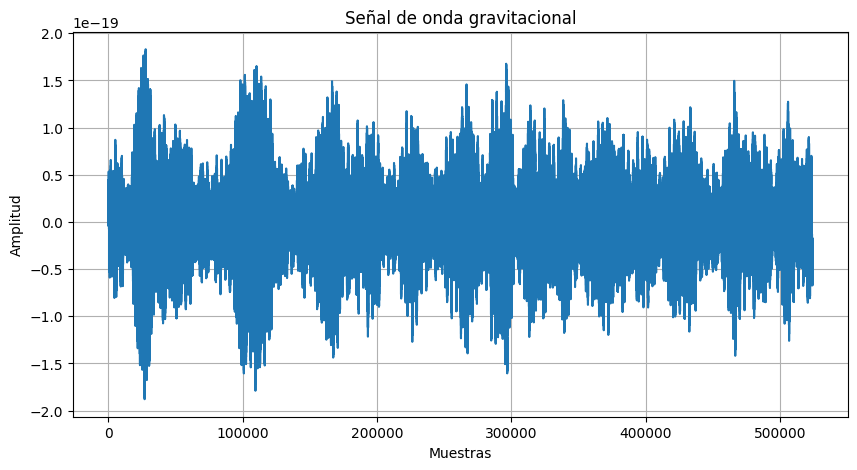

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data=pd.read_csv('H-H1_GWOSC_16KHZ_R1-1264316101-32.txt') #Leo el archivo descomprimido y lo guardo en un dataframe
data
# cargar datos


#Se importa archivo saltandose las filas que no sirven
data = np.loadtxt("H-H1_GWOSC_16KHZ_R1-1264316101-32.txt", delimiter = ",", skiprows = 1, dtype = float)
print (data[:10])

#Se grafica la señal
plt.figure(figsize=(10, 5)) #Se le da un tamaño a la grafica
plt.plot(data) #Se grafica los primeros 1000 datos
plt.title("Señal de onda gravitacional") # Titulo de la grafica
plt.xlabel("Muestras") #Etiqueta eje x
plt.ylabel("Amplitud") #Etiqueta eje y
plt.grid() #Se le pone una grilla a la grafica
plt.savefig("Señalgravitacional.png")
plt.show() #Se muestra la grafica

## 2. Convertir en audio
Es una forma de validar que tenemos un alto componente de ruido en la señal y que el interés es eliminarlo para encontrar una señal candidata.

Te recomiendo hacer una señal de audio de cada uno de las etapas para así validar como va el proceso. Al final deberás obtener un señal con CHIRP o BUMP. Son sonidos que comprueban que tienes una cantidad de potencia que sobre destaca sobre el ruido.

In [2]:

fs = 16000 #Frecuencia de muestreo
time = np.linspace(0, data.size / fs, data.size) #Creación vector tiempo

lowTime = 0 #Tiempo de intervalo donde empieza recorte
highTime = 32 #Tiempo de intervalo donde termina recorte
lowSample = lowTime*fs #Muestras en tiempo bajo
highSample = highTime*fs #Muestras en tiempo alto

strainSteps = data[lowSample:highSample] #Señal de audio recortada

timeSteps = np.linspace(lowTime, highTime, strainSteps.size) #Vector tiempo recortado




In [5]:
from IPython.display import Audio

#Reproducción de audio original
Audio(data, rate = fs)

# Señal original en los 32 segundos

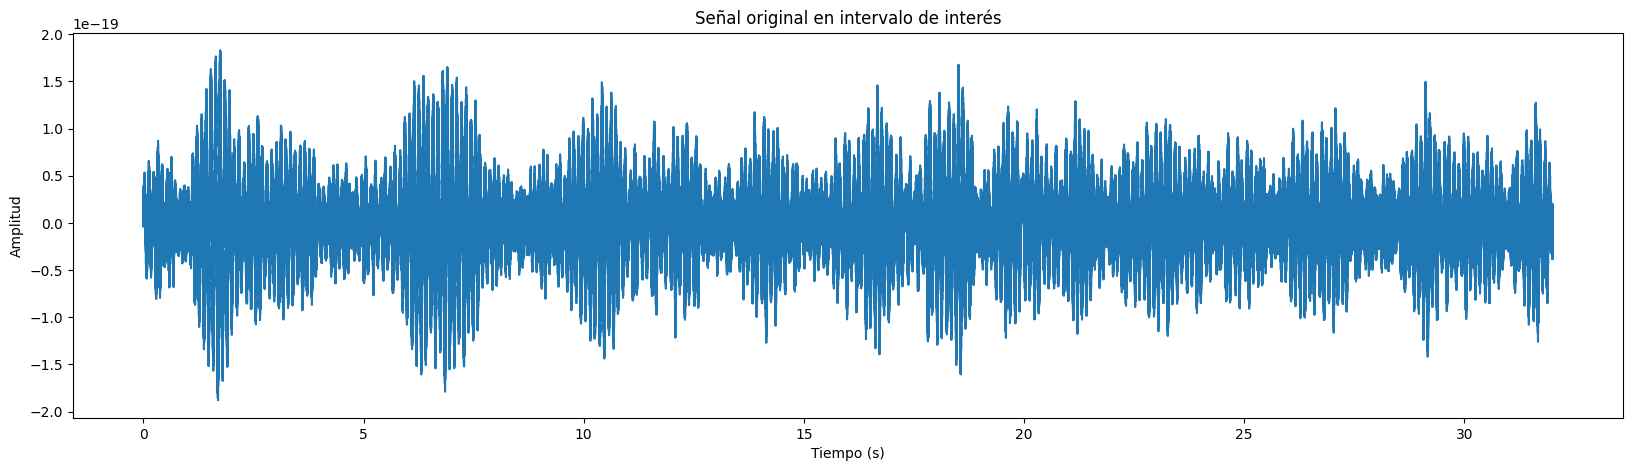

In [39]:
#Gráfica de señal de audio original
plt.figure(figsize=(20, 5))
plt.plot(timeSteps, strainSteps)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Señal original en intervalo de interés")
plt.savefig("Señalgravitacional32segundos.png")

# Señal gravitatoria agregandole data chirp

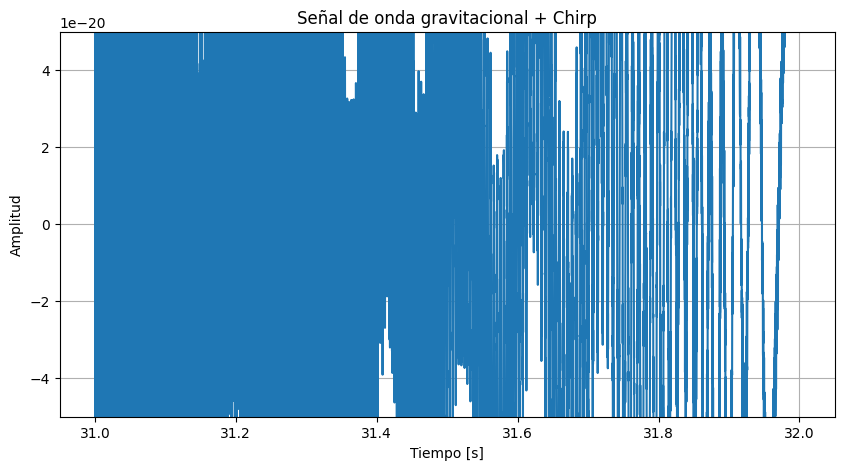

In [ ]:
from scipy.signal import chirp
# Generar chirp: frecuencia lineal de 200 Hz a 2000 Hz en 32 segundos
chirp_signal = chirp(timeSteps, f0=0, f1=16000, t1=32, method='linear')

# Normalizar el chirp para que no sobresature la señal original
chirp_signal *= 0.5 * np.max(np.abs(strainSteps)) / np.max(np.abs(chirp_signal))

# Sumar chirp a la señal original
data_with_chirp = strainSteps + chirp_signal

# Mostrar ultimo segundo
start = int(31 * fs)
end = int(32 * fs)

# Graficar señal con chirp en un intervalo acotado
plt.figure(figsize=(10, 5))
plt.plot(timeSteps[start:end], data_with_chirp[start:end])
plt.title("Señal de onda gravitacional + Chirp")
plt.xlabel("Tiempo [s]")
plt.ylim(-0.5e-19,0.5e-19)
plt.ylabel("Amplitud")
plt.grid()
plt.savefig("Señalchirp.png")
plt.show()

# Reproducir señal como audio
Audio(data_with_chirp, rate=fs)

## 3. Análisis de Fourier
Al realizar la conversión, queremos ver cuales son las componentes de ruido que más afectan al instrumento y debemos ignorar en el análisis. Eso se ve como "pico" o la apariencia de "peine".
Se debe presenta la densidad espectral de potencia antes y después de la función de Windowing.


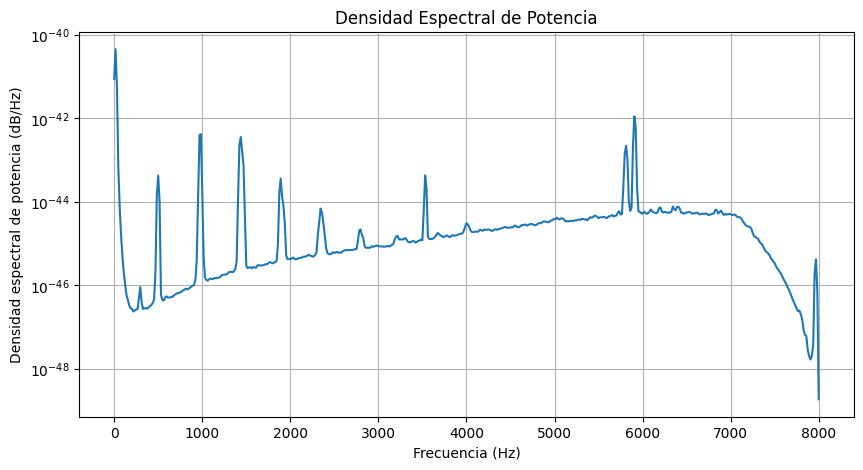

In [41]:
from scipy.signal import welch

# Estimación de la densidad espectral de potencia usando el método de Welch
frequencies, power_density = welch(strainSteps, fs, nperseg=1024)

# Graficar la densidad espectral de potencia
plt.figure(figsize=(10, 5))
plt.semilogy(frequencies, power_density)  # Usamos escala logarítmica para mayor claridad
plt.title("Densidad Espectral de Potencia")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Densidad espectral de potencia (dB/Hz)")
plt.grid()
plt.savefig("Densidadespectra.png")
plt.show()

# Transformada de fourier con ventana tukey

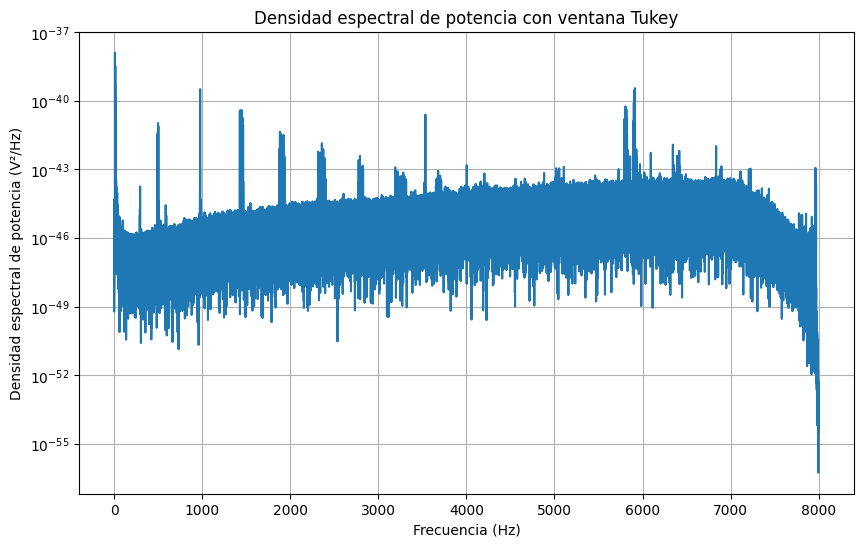

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.signal.windows import tukey

# Parámetros
fs = 16000            # Frecuencia de muestreo original (Hz)
nperseg = 524288      # Longitud del segmento para Welch
alpha = 0.5           # Parámetro de forma de la ventana Tukey

# Crear la ventana Tukey
ventana = tukey(nperseg, alpha)

# Asegurarse de que hay suficientes muestras
if len(strainSteps) < nperseg:
    strainSteps = np.pad(strainSteps, (0, nperseg - len(strainSteps)), 'constant')

# Calcular la Densidad Espectral de Potencia
frequencies, psd = welch(strainSteps, fs=fs, window=ventana, nperseg=nperseg, noverlap=128)

# Graficar
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, psd)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Densidad espectral de potencia (V²/Hz)')
plt.title('Densidad espectral de potencia con ventana Tukey')
plt.grid()
plt.savefig("Densidadespectraltukey.png")
plt.show()



## 4. Procesamiento 
Debes inferir de tu estudio, cual es el proceso que aplican a la señal y reproducirlo. Es posible que cada estudiante llegue a una solución más o menos diferente, pues no hay un código abierto donde esté el procedimiento completo.


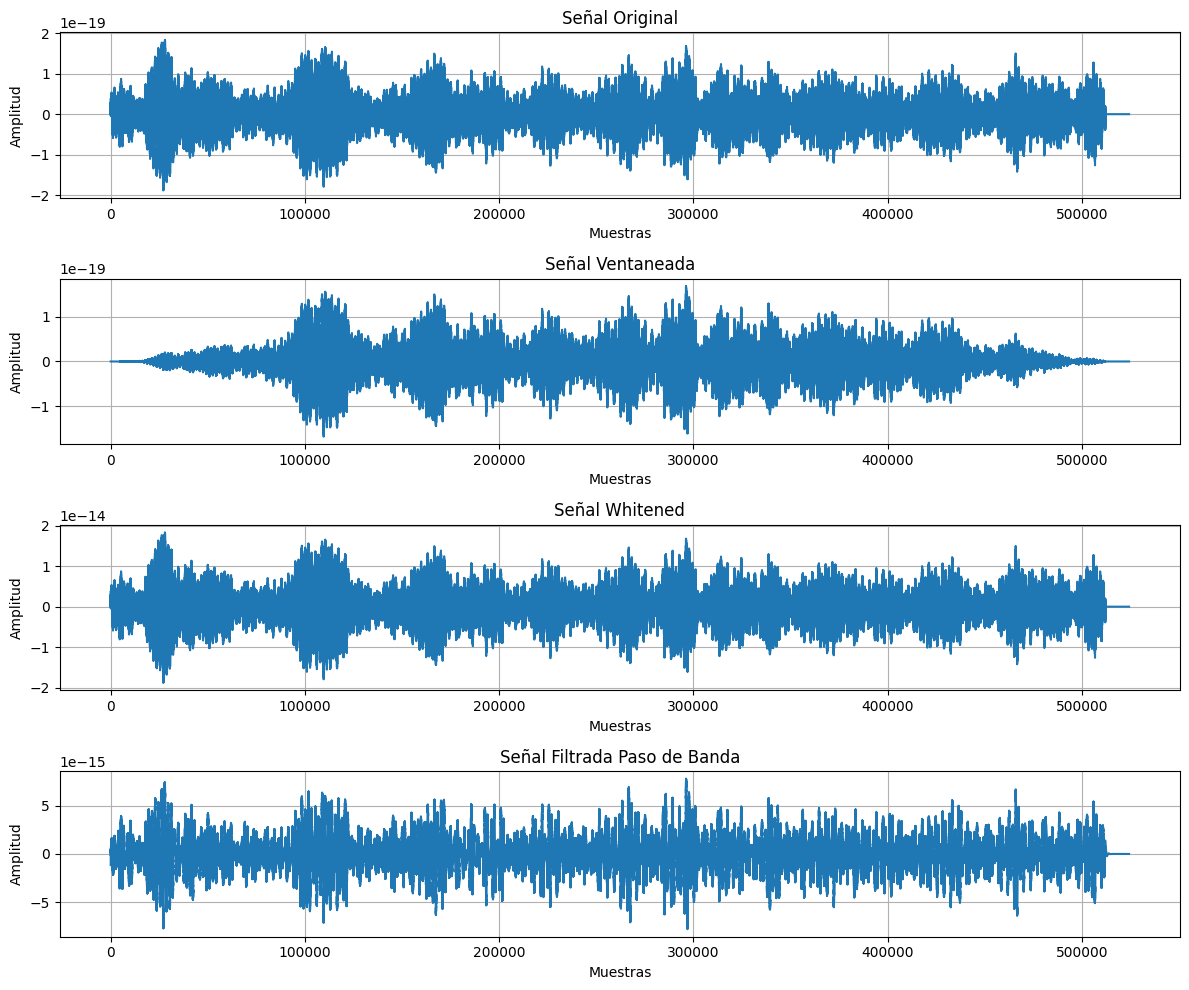

In [43]:
from scipy.signal import butter, filtfilt
# Whitening de la señal
psd_safe = np.maximum(psd, 1e-10)  # Evitar valores cero en el PSD

# Interpolamos el PSD para que tenga la misma longitud que strainSteps
psd_interpolated = np.interp(np.linspace(0, 1, strainSteps.size), np.linspace(0, 1, psd_safe.size), psd_safe)

# Normalizamos la señal según el PSD interpolado
whitened_signal = strainSteps / np.sqrt(psd_interpolated)

# Frecuencias de corte para el filtro paso de banda
low_cutoff = 10  # Frecuencia de corte baja (Hz)
high_cutoff = 1000  # Frecuencia de corte alta (Hz)

# Crear el filtro paso de banda Butterworth (orden 4)
b, a = butter(4, [low_cutoff / (0.5 * fs), high_cutoff / (0.5 * fs)], btype='bandpass')

# Filtrar la señal whitened
bandpassed_signal = filtfilt(b, a, whitened_signal)

# Graficar los resultados
plt.figure(figsize=(12, 10))

# Señal original
plt.subplot(4, 1, 1)
plt.plot(strainSteps)
plt.title('Señal Original')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid()

# Señal ventaneada
plt.subplot(4, 1, 2)
plt.plot(ventana * strainSteps)  # Señal ventaneada
plt.title('Señal Ventaneada')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid()


# Señal whitened
plt.subplot(4, 1, 3)
plt.plot(whitened_signal)
plt.title('Señal Whitened')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid()

# Señal filtrada paso de banda
plt.subplot(4, 1, 4)
plt.plot(bandpassed_signal)
plt.title('Señal Filtrada Paso de Banda')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid()

plt.tight_layout()
plt.savefig("3graficos.png")
plt.show()







# Resampling
Para lograr una mejor definición de la señal, se debe hacer un resampleo. Esto tienen consecuencias por eso debe elegirse bien la frecuencia de tal forma que no se introduzca ruido.

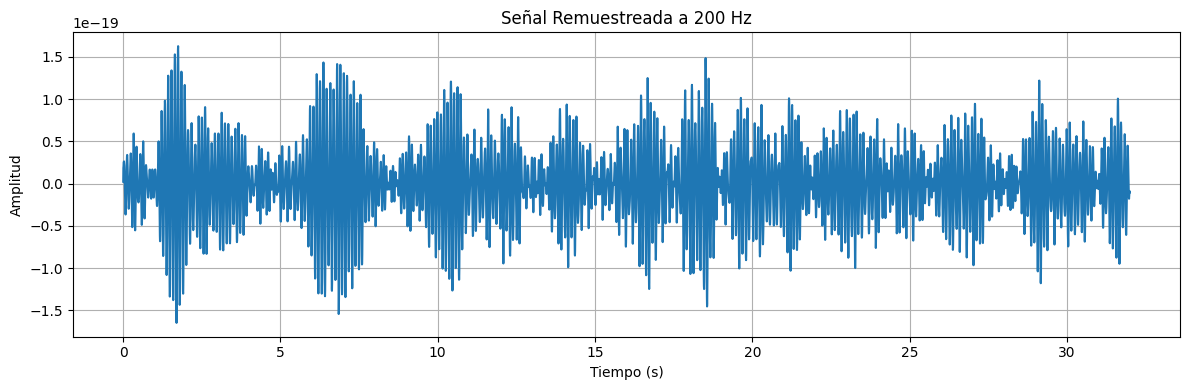

In [ ]:
from scipy.signal import resample
import numpy as np
import matplotlib.pyplot as plt

# Frecuencias
fs_original = 16000     # Frecuencia original (Hz)
fs_nueva = 200          # Nueva frecuencia deseada (Hz)

# Duración de la señal original en segundos
duracion = len(strainSteps) / fs_original

# Número de muestras en la nueva señal
n_muestras_nueva = int(duracion * fs_nueva)

# Remuestreo
signal_resampled = resample(strainSteps, n_muestras_nueva)

# Nuevo eje temporal
t_resampled = np.linspace(0, duracion, n_muestras_nueva)

# Gráfica
plt.figure(figsize=(12, 4))
plt.plot(t_resampled, signal_resampled)
plt.title("Señal Remuestreada a 200 Hz")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()
plt.tight_layout()
plt.savefig("resampleo.png")
plt.show()




# Espectograma


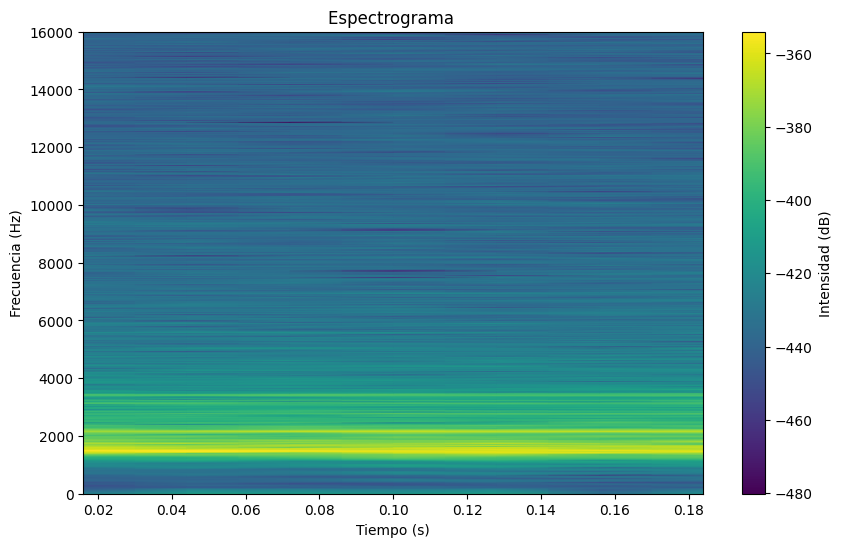

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, welch

# Frecuencia de muestreo elevada para cubrir hasta 16 kHz
fs_resampled = 32000  # Hz

# Calcular la densidad espectral de potencia (PSD) con Welch
frequencies, psd = welch(signal_resampled, fs=fs_resampled, nperseg=1024)
psd_safe = np.maximum(psd, 1e-10)  # evitar división por cero

# Calcular el espectrograma
frequencies_spec, times_spec, Sxx = spectrogram(signal_resampled, fs=fs_resampled, nperseg=1024)

# Interpolar la PSD a las frecuencias del espectrograma
psd_interpolated = np.interp(frequencies_spec, frequencies, psd_safe)

# Normalizar el espectrograma con la PSD (Livingston)
Sxx_normalized = Sxx / np.sqrt(np.outer(psd_interpolated, np.ones(len(times_spec))))

# Graficar espectrograma normalizado (solo hasta 16 kHz)
plt.figure(figsize=(10, 6))
plt.pcolormesh(times_spec, frequencies_spec, 10 * np.log10(Sxx_normalized), shading='gouraud')
plt.ylim(0, 16000)  # Mostrar hasta 16 kHz
plt.colorbar(label='Intensidad (dB)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia (Hz)')
plt.title('Espectrograma ')
plt.savefig("espectograma.png")
plt.show()




